In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Input, BatchNormalization, Conv2D, Conv2DTranspose, Activation
from keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.applications import VGG16
from keras import backend as K

In [ ]:
def load_data(data_dir, img_size=(128, 128)):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        for img_file in os.listdir(os.path.join(data_dir, label)):
            img_path = os.path.join(data_dir, label, img_file)
            if img_file.lower().endswith(('.jpeg','.jpg')):
                try:
                    img = load_img(img_path, target_size=img_size)
                    img = img_to_array(img) / 255.0
                    images.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
                    continue
    return np.array(images), np.array(labels)

data_dir = '/content/drive/MyDrive/dataset_image'  # Update this path
X, y = load_data(data_dir)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


Error loading image /content/drive/MyDrive/dataset_image/Ocimum Tenuiflorum (Tulsi)/holy-basil-tulsi-leaves-isolated-white_256988-866.jpg: cannot identify image file <_io.BytesIO object at 0x7a338e0169d0>


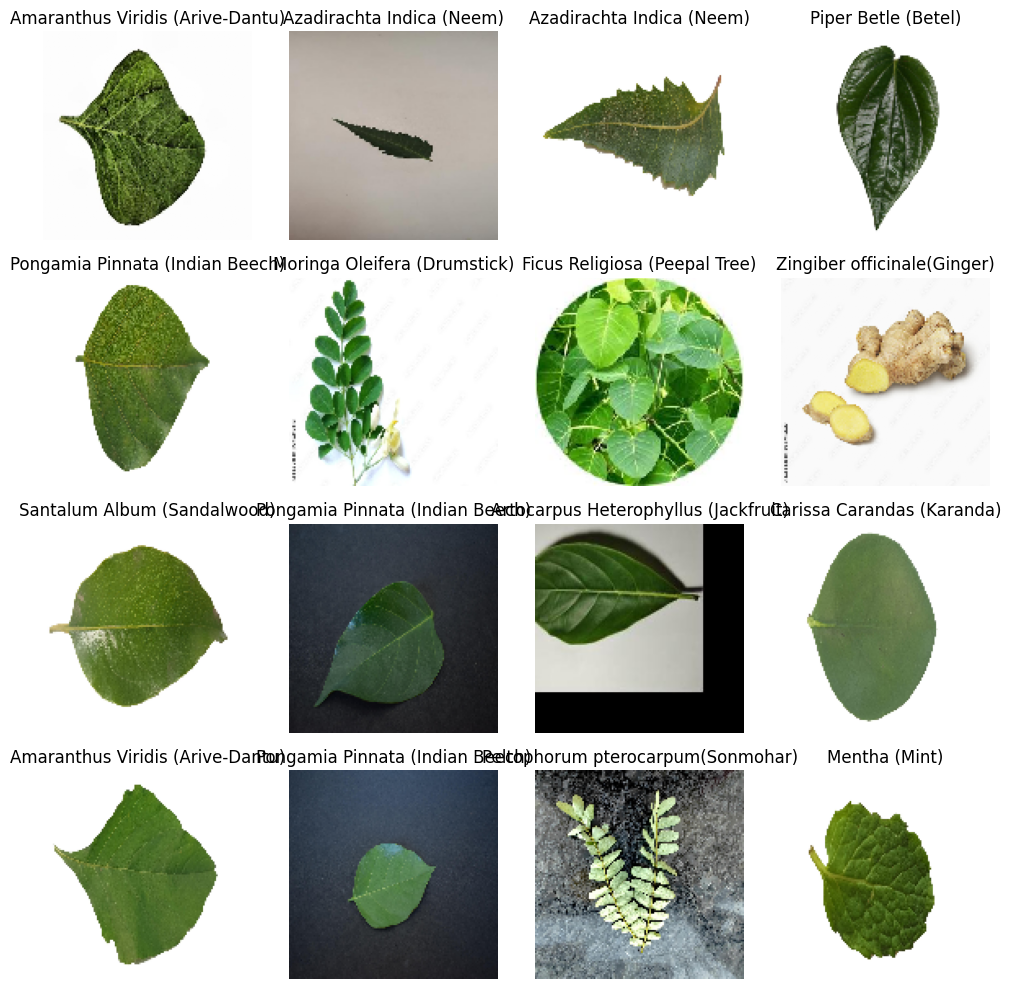

In [ ]:
# prompt: display the an  image of all speicies with the species name in terms of rows and columns

import matplotlib.pyplot as plt
import numpy as np

# Assuming X contains the images and y contains the corresponding labels
# from the previous code.

# Number of images to display per row and column. Adjust accordingly.
rows = 4
cols = 4
num_images = rows * cols

# Select random images to display
indices = np.random.choice(len(X), size=min(num_images, len(X)), replace=False)

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, index in enumerate(indices):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(X[index])
    ax.set_title(y[index])
    ax.axis('off')  # Turn off axis ticks and labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Build Generator (DCGAN)
def build_generator(latent_dim, num_classes):
    model = Sequential()
    model.add(Dense(128 * 32 * 32, activation="relu", input_dim=latent_dim + num_classes))
    model.add(Reshape((32, 32, 128)))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', activation='tanh'))
    return model

In [ ]:
# Build Critic (WGAN Discriminator)
def build_critic(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128, activation=LeakyReLU(alpha=0.2)))
    model.add(Dropout(0.3))
    model.add(Dense(1))  # No activation for WGAN
    return model

In [ ]:
# Build GAN
def build_gan(generator, critic):
    critic.compile(loss='mean_squared_error', optimizer=Adam(0.0002, 0.5))
    critic.trainable = False
    gan_input = Input(shape=(latent_dim + num_classes,))
    img = generator(gan_input)
    gan_output = critic(img)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='mean_squared_error', optimizer=Adam(0.0002, 0.5))
    return gan

In [ ]:
# Define latent_dim and num_classes
latent_dim = 100
num_classes = len(np.unique(y))

img_shape = (128, 128, 3)
generator = build_generator(latent_dim, num_classes)
critic = build_critic(img_shape)
gan = build_gan(generator, critic)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
# Training the WGAN
def train_gan(epochs, batch_size, latent_dim, n_critic=5):
    for epoch in range(epochs):
        for _ in range(n_critic):  # Train the critic more frequently
            idx = np.random.randint(0, X.shape[0], batch_size)
            real_imgs = X[idx]
            labels = y[idx]

            # One-hot encode labels
            labels_encoded = np.zeros((batch_size, num_classes))
            labels_encoded[np.arange(batch_size), LabelEncoder().fit(y).transform(labels)] = 1

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            noise_with_labels = np.concatenate((noise, labels_encoded), axis=1)
            fake_imgs = generator.predict(noise_with_labels)

            # Train the critic
            d_loss_real = critic.train_on_batch(real_imgs, np.ones((batch_size, 1)))
            d_loss_fake = critic.train_on_batch(fake_imgs, -np.ones((batch_size, 1)))  # WGAN uses -1 for fake
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        noise_with_labels = np.concatenate((noise, labels_encoded), axis=1)
        g_loss = gan.train_on_batch(noise_with_labels, np.ones((batch_size, 1)))

        # Print losses
        #if epoch % 10 == 0:
            #print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")

# Train the GAN
train_gan(epochs=1000, batch_size=32, latent_dim=latent_dim)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

In [ ]:
# Updated function to generate synthetic images
def generate_images(generator, num_images):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    labels = np.random.randint(0, num_classes, num_images)
    labels_encoded = np.zeros((num_images, num_classes))
    labels_encoded[np.arange(num_images), labels] = 1
    noise_with_labels = np.concatenate((noise, labels_encoded), axis=1)
    generated_images = generator.predict(noise_with_labels)
    generated_images = (generated_images + 1) / 2.0  # Scale from [-1, 1] to [0, 1]
    generated_images = np.clip(generated_images, 0, 1)  # Ensure values are in [0, 1]
    return generated_images

# After generating synthetic images
synthetic_images = generate_images(generator, 500)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step


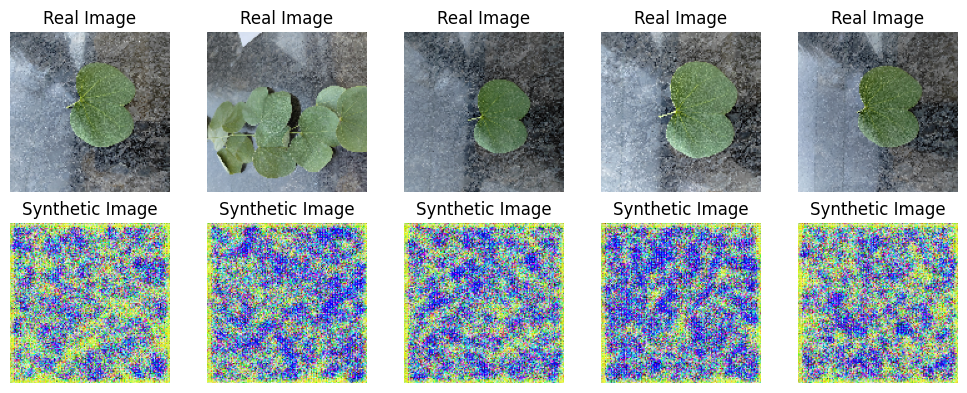

In [ ]:
# Function to display the first 5 real and synthetic images
def display_real_and_synthetic_images(real_images, synthetic_images, num_images=5):
    plt.figure(figsize=(10, 4))

    # Display real images
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(real_images[i])  # No cmap argument for color images
        plt.axis('off')  # Hide the axis
        plt.title("Real Image")

    # Display synthetic images
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(synthetic_images[i])  # No cmap argument for color images
        plt.axis('off')  # Hide the axis
        plt.title("Synthetic Image")

    plt.tight_layout()
    plt.show()

# Display the first 5 real images and the first 5 synthetic images
display_real_and_synthetic_images(X, synthetic_images)

In [ ]:
# Feature extraction
def extract_features(images):
    model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    features = model.predict(images)
    return features.reshape(features.shape[0], -1)

real_features = extract_features(X)

# Combine features and labels only for real images
combined_features = real_features
combined_labels = y

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(combined_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, encoded_labels, test_size=0.2, random_state=42)

# Train the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)

# Generate classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Calculate accuracy
accuracy = logistic_model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step
                                              precision    recall  f1-score   support

            Amaranthus Viridis (Arive-Dantu)       0.96      0.80      0.87        59
        Artocarpus Heterophyllus (Jackfruit)       0.96      0.96      0.96        52
                   Azadirachta Indica (Neem)       0.96      0.94      0.95        53
                     Bauhinia racemosa(Apta)       0.91      0.94      0.93        72
                  Carissa Carandas (Karanda)       0.91      0.91      0.91        74
                        Citrus Limon (Lemon)       0.98      0.98      0.98        64
                         Eucalyptus(Nilgiri)       0.90      0.94      0.92        64
               Ficus Religiosa (Peepal Tree)       0.91      0.87      0.89        61
                          Jasminum (Jasmine)       1.00      0.97      0.98        33
                    Mangifera Indica (Mango) 

In [ ]:
# Compute and print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[47  0  0  1  0  0  1  1  0  0  5  0  0  2  0  1  0  0  1  0]
 [ 0 50  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0  1  2  0  0  0  0  0  0  0]
 [ 0  0  0 68  0  0  1  2  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  1 67  1  0  0  0  0  0  1  1  0  0  0  0  0  2  1]
 [ 0  0  0  0  0 63  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 60  2  0  1  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  2  1  0  1 53  0  1  1  1  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 32  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0 51  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 50  0  0  2  1  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  1 48  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0 35  0  0  0  0  0  0  0]
 [ 0  1  1  0  1  0  0  0  0  0  7  1  0 52  3  1  0  1  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0 67  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0

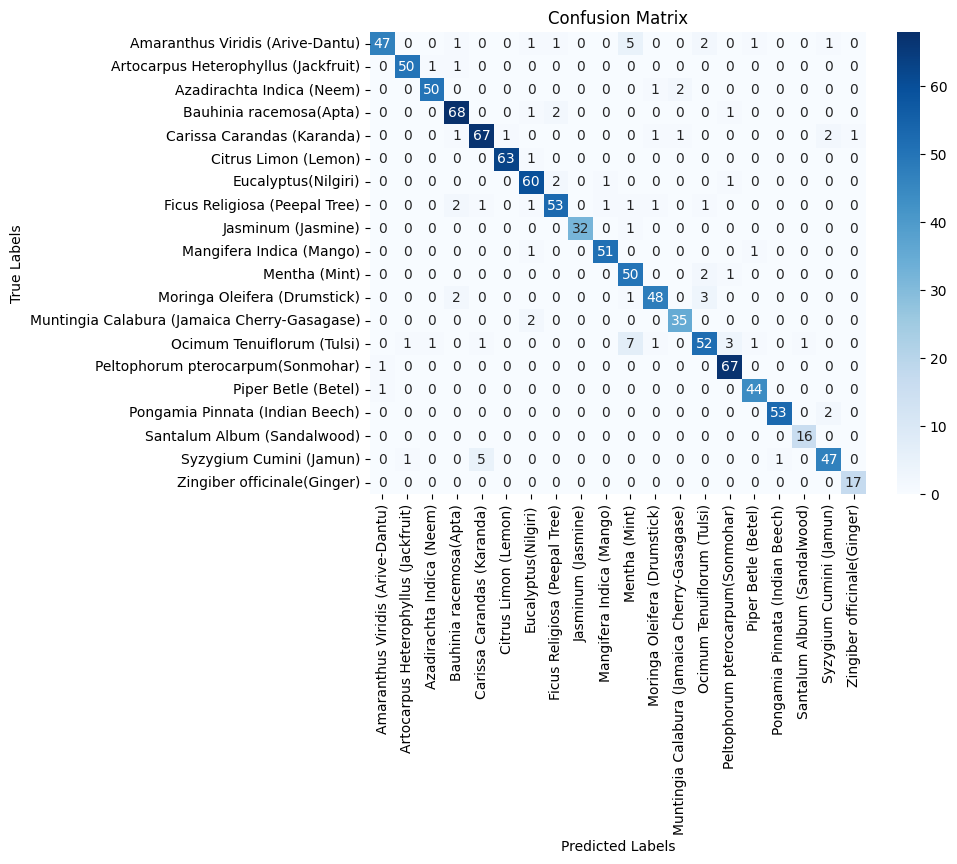

In [ ]:
# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# prompt: calculate the precision,recall,F1-score,false positive rate,calculate the AUC-PR

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
import numpy as np

# Assuming y_test and y_pred are already defined from the previous code

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Calculate the False Positive Rate (FPR)
# For multi-class, you need to consider all classes
cm = confusion_matrix(y_test, y_pred)  # Get the confusion matrix
FP = cm.sum(axis=0) - np.diag(cm)  # Sum of all False Positives for each class
FN = cm.sum(axis=1) - np.diag(cm)  # Sum of all False Negatives for each class
TP = np.diag(cm)  # Sum of all True Positives for each class
TN = cm.sum() - (FP + FN + TP) # Sum of all True Negatives for each class


# For macro-average FPR (average across all classes)
fpr_macro = np.mean(FP / (FP + TN))
print(f"Macro-Averaged False Positive Rate: {fpr_macro}")

# For micro-average FPR (considering all samples)
fpr_micro = FP.sum() / (FP.sum() + TN.sum())
print(f"Micro-Averaged False Positive Rate: {fpr_micro}")



# Calculate AUC-PR (Area Under the Precision-Recall Curve)
# Note: For AUC-PR, you need probability estimates, not just class predictions
y_prob = logistic_model.predict_proba(X_test)  # Get probability estimates
auc_pr = average_precision_score(y_test, y_prob, average='weighted') # Use average='weighted' for multi-class
print(f"AUC-PR: {auc_pr}")

Precision: 0.9239144714945396
Recall: 0.9220532319391636
F1-score: 0.9216435280123273
Macro-Averaged False Positive Rate: 0.004129547332697933
Micro-Averaged False Positive Rate: 0.004102461476886132
AUC-PR: 0.9731814888906969


In [ ]:
# prompt: calculate the macro averaged F1-score

from sklearn.metrics import f1_score

# Assuming y_test and y_pred are already defined from the previous code
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Macro-averaged F1-score: {f1_macro}")


Macro-averaged F1-score: 0.9279564687599615


In [ ]:
import joblib
from keras.models import save_model

# Save the logistic regression model
joblib.dump(logistic_model, 'logistic_model.pkl')

# Save the VGG16 feature extractor
vgg16_feature_extractor = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
save_model(vgg16_feature_extractor, 'vgg16_feature_extractor.keras')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [ ]:
# prompt: use the above loaded logistic model in order to evaluate it in terms of  repeated stratified k-fold cross-validation.

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
import joblib # Import joblib for loading the model


# Load the logistic regression model
loaded_logistic_model = joblib.load('logistic_model.pkl') # Load the model and assign it to loaded_logistic_model


# Define the cross-validation method
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Initialize lists to store results
accuracy_scores = []

# Loop through each fold
for train_index, test_index in rskf.split(combined_features, encoded_labels):
    # Split data for the current fold
    X_train, X_test = combined_features[train_index], combined_features[test_index]
    y_train, y_test = encoded_labels[train_index], encoded_labels[test_index]

    # Train the model on the training data for this fold
    logistic_model.fit(X_train, y_train)

    # Make predictions on the testing data for this fold
    y_pred = loaded_logistic_model.predict(X_test) # Use loaded_logistic_model for predictions

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", accuracy_scores)

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(accuracy_scores)
print(f"Mean Accuracy: {mean_accuracy}")

# Calculate and print the standard deviation of accuracy scores
std_accuracy = np.std(accuracy_scores)
print(f"Standard Deviation of Accuracy: {std_accuracy}")

Accuracy scores for each fold: [0.9876425855513308, 0.9800380228136882, 0.9866920152091255, 0.9866920152091255, 0.9809705042816366, 0.9876425855513308, 0.9819391634980988, 0.9838403041825095, 0.9847908745247148, 0.9838249286393911, 0.9857414448669202, 0.9800380228136882, 0.9876425855513308, 0.9762357414448669, 0.9923882017126546]
Mean Accuracy: 0.9844079330566942
Standard Deviation of Accuracy: 0.0039241335501335375


In [ ]:
# Predicting new images
def load_and_preprocess_image(image_path, img_size=(128, 128)):
    img = load_img(image_path, target_size=img_size)
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_image(image_path, model, feature_extractor):
    img = load_and_preprocess_image(image_path)
    features = feature_extractor.predict(img)
    features = features.reshape(features.shape[0], -1)
    prediction = model.predict(features)
    return prediction

# Example usage
image_path ='/content/ginger-root.jpg'  # Replace with the path to your test image
img = load_img(image_path, target_size=(128, 128))  # Load with target size for display
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Load feature extractor once outside the prediction function
feature_extractor = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

predicted_class = predict_image(image_path, logistic_model, feature_extractor)

# Decode the predicted class
predicted_label = le.inverse_transform(predicted_class)
print(f"Predicted class: {predicted_label[0]}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/ginger-root.jpg'